In [1]:
import json
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import copy

import dijkstra as dijk
import stacked_graph as sg
import hardware as hw
import testing as test
import graph_visualization as gv
import data_collection as dc

# 1

In [2]:

# read_json_path = '/home/rjtomich/photonic_compiler/model_to_graph/gpt2_graph.json'
# # read_json_path = '/home/rjtomich/photonic_compiler/model_to_graph/bert-base-uncased_graph.json'
# # read_json_path = '/home/rjtomich/photonic_compiler/Pytorch-LeNet/simple_LeNet_graph.json'
# # read_json_path = '/home/rjtomich/photonic_compiler/Pytorch-LeNet/simple_LeNet_graph_NoFusion.json'
# with open(read_json_path)  as json_file:
#     raw_json = json.load(json_file) # returns json file as dict

# graph = sg.StackedGraph(raw_json=raw_json)

# subgraphs = list(dijk.graph_partition(graph))
# dijk.select_nodes(graph, subgraphs)


In [3]:
# groups = list(graph.get_node_groups(asap = False))
# print(test.group_validate(graph, groups))
# for group in groups:
#     print(group)


In [4]:
# n_graphs = len(groups)
# n_cols = 6  # Number of columns for the grid
# n_rows = (n_graphs + n_cols - 1) // n_cols  # Calculate the number of rows needed

# fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 3))
# axes = axes.flatten()  # Flatten the array of axes


# for i in range(len(groups)):
#     if i >= 0:
#         test_group = groups[i]

#         start_stack = sg.StackedNode(0, [], [[]], [[]], opp='start', func_stack=['start'], cost_stack=[0])
#         first_stack = copy.deepcopy(graph.stack_list[graph.id_to_idx[test_group[0]]])
#         first_stack.parents = [0]

#         subgraph_stack_list = [start_stack, first_stack]
#         for stack_id in test_group[1:]:
#             stack = graph.stack_list[graph.id_to_idx[stack_id]]
#             new_node = copy.deepcopy(stack)
#             new_node.parents = set(new_node.parents) - graph.in_nodes
#             subgraph_stack_list.append(new_node)


#         new_graph = sg.StackedGraph(stack_list=subgraph_stack_list)
#         # gv.adj_to_graph(new_graph.adj_matrix, save=False, layout = 'spectral')
#         # gv.adj_to_graph(new_graph, save=False, layout = 'kk', title = f'Subgraph {i}')
#         gv.adj_to_graph(new_graph, ax=axes[i], layout='kk', title=f'Subgraph {i+1}')


# for j in range(i + 1, len(axes)):
#     fig.delaxes(axes[j])


# plt.tight_layout()
# plt.show()


# 2 Graph Visualization

In [2]:
subgraph_to_plot = 3

WEIGHT_VARIABLE = 'time'
config = None

read_json_path = '/home/rjtomich/photonic_compiler/model_to_graph/gpt2_graph.json'
# read_json_path = '/home/rjtomich/photonic_compiler/model_to_graph/bert-base-uncased_graph.json'
# read_json_path = '/home/rjtomich/photonic_compiler/Pytorch-LeNet/simple_LeNet_graph.json'
# read_json_path = '/home/rjtomich/photonic_compiler/Pytorch-LeNet/simple_LeNet_graph_NoFusion.json'
with open(read_json_path)  as json_file:
    raw_json = json.load(json_file) # returns json file as dict

graph = sg.StackGraph(raw_json=raw_json, weight_variable=WEIGHT_VARIABLE)
stacked_subgraphs = list(dijk.graph_partition(graph))
flat_subgraphs = dijk.select_nodes(
    stacked_subgraphs, weight_variable=WEIGHT_VARIABLE, config=config
)
expanded_flat_subgraphs = dijk.expand_nodes(flat_subgraphs)
print(len(expanded_flat_subgraphs))


28


In [3]:
def draw_subgraphs(subgraph, sub = False):
    fig, ax = plt.subplots(figsize=(10, 10))

    gv.adj_to_graph(subgraph, ax=ax, layout='kk', title=f'Subgraph')
    # plt.tight_layout()
    plt.show()

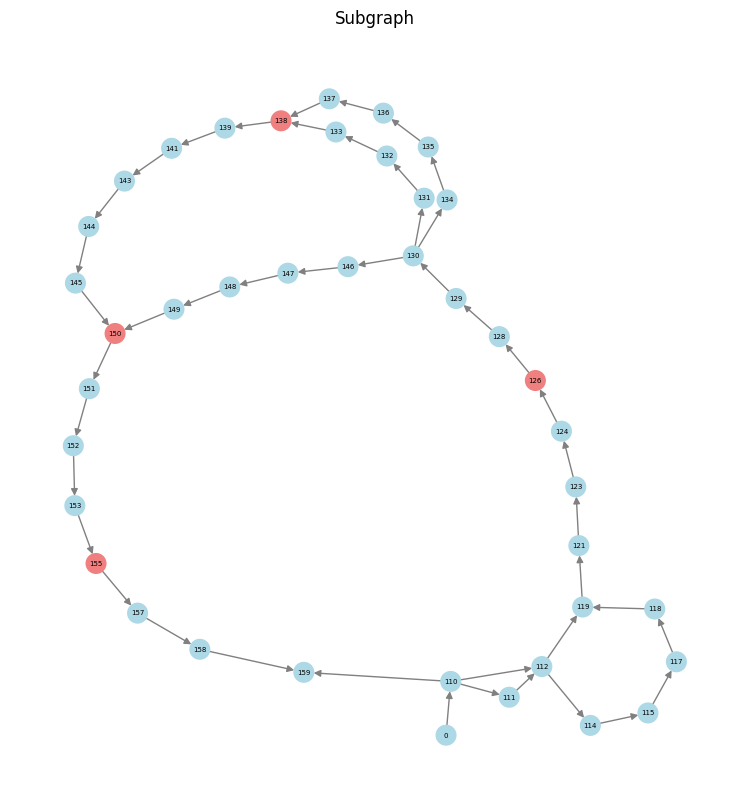

In [4]:
draw_subgraphs(flat_subgraphs[subgraph_to_plot])


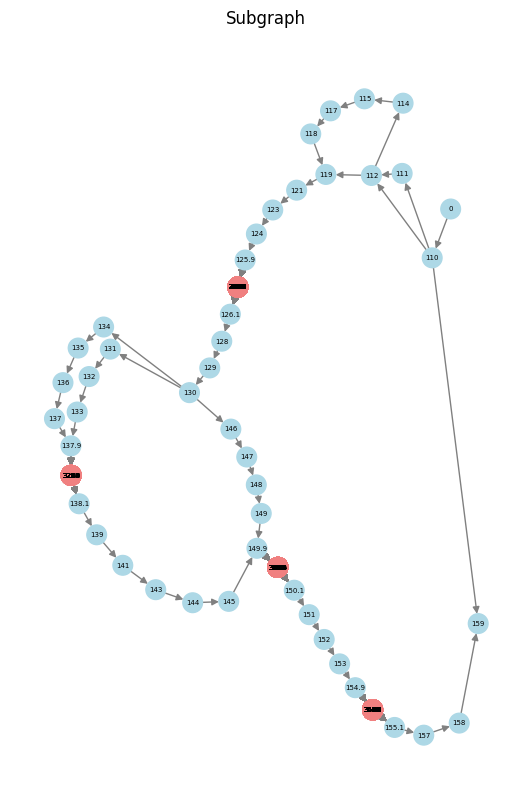

In [5]:
# draw_subgraphs(graph)
# draw_subgraphs(graph)
draw_subgraphs(expanded_flat_subgraphs[subgraph_to_plot])
# draw_subgraphs(graph, sub='all')

# 3 Timeline Visualization

{'<hardware.CPU object at 0x7f33019b16a0>0', 'memory', '<hardware.SRAM object at 0x7f3298708110>0'}
1108
(1108, 4)


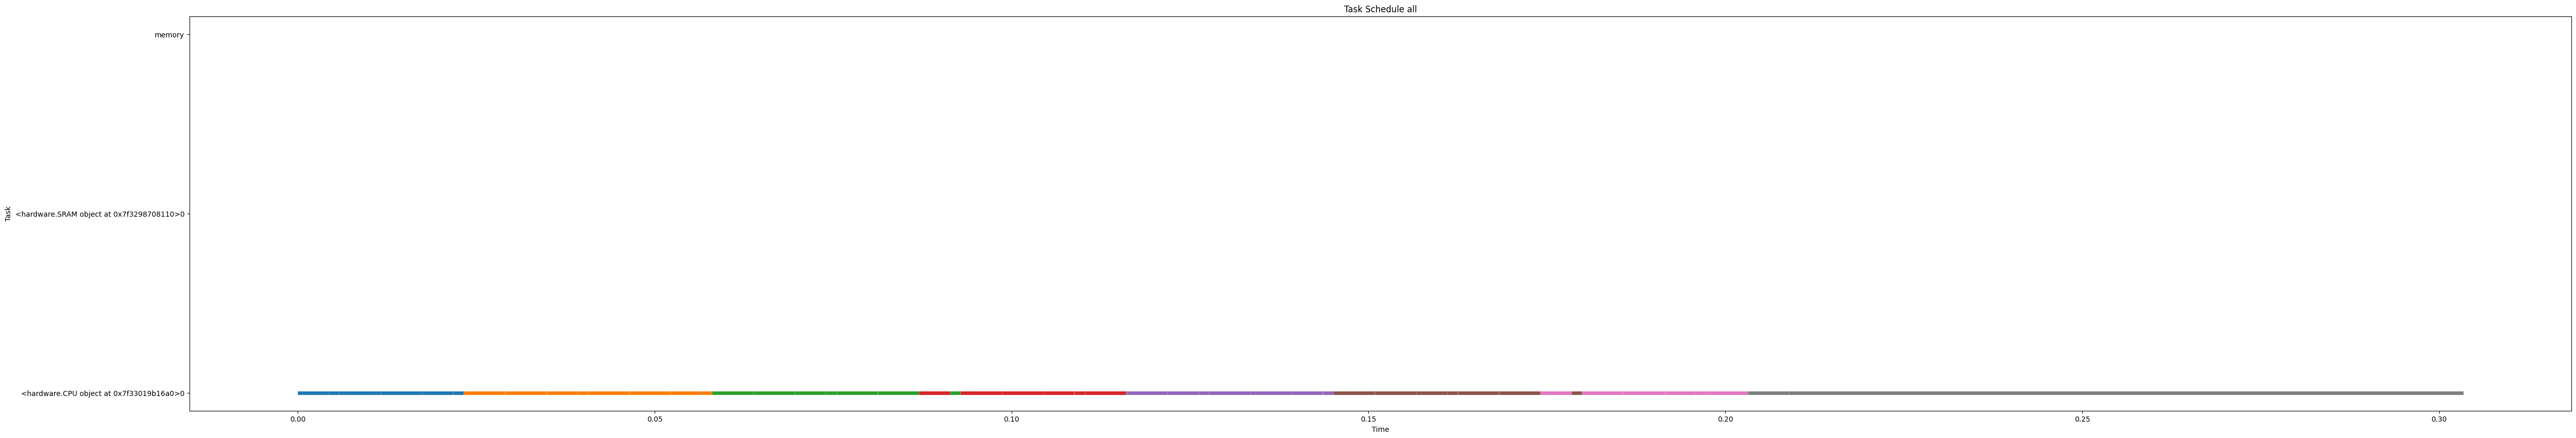

end_time=0.30336


In [2]:
available_hardware = hw.initilize_hardware([hw.CPU(3269320700, 1)])

JSON_PATH = "/home/rjtomich/photonic_compiler/model_to_graph/gpt2_graph.json"
# JSON_PATH = '/home/rjtomich/photonic_compiler/model_to_graph/bert-base-uncased_graph.json'
# JSON_PATH = '/home/rjtomich/photonic_compiler/Pytorch-LeNet/simple_LeNet_graph.json'
# JSON_PATH = '/home/rjtomich/photonic_compiler/Pytorch-LeNet/simple_LeNet_graph_NoFusion.json'
with open(JSON_PATH, encoding="utf-8") as json_file:
    raw_json = json.load(json_file)  # returns json file as dict
    # print("... Json loaded ...")

WEIGHT_VARIABLE = "time"
# WEIGHT_VARIABLE = "energy"

# config = None
# config = 'always_cpu'
config = 'always_phu'

graph = sg.StackGraph(raw_json=raw_json, weight_variable=WEIGHT_VARIABLE)
stacked_subgraphs = list(dijk.graph_partition(graph))
flat_subgraphs = dijk.select_nodes(
    stacked_subgraphs, weight_variable=WEIGHT_VARIABLE, config=config
)
expanded_flat_subgraphs = dijk.expand_nodes(flat_subgraphs)
scheduled_flat_graph, end_time, break_points = dijk.schdeule_nodes(
    graph, expanded_flat_subgraphs, available_hardware
)

hardware = set()
for node in scheduled_flat_graph.node_list:
    # if stack.hardware_selection is None:
    #     print(stack)
    hardware.add(node.hardware_selection)
    assert node.hardware_selection is not None
print(hardware)
print(len(scheduled_flat_graph.node_list))

break_points.sort()
gv.make_schedule_diagram(scheduled_flat_graph, xlim_start=None, xlim_end=None)
# gv.make_schedule_diagram(graph, xlim_start=0, xlim_end=0.1)

# # PLOT EACH SUBSECTION
# for i in range(len(break_points)-1):
#     print(i)
#     print(f'{break_points[i]} - {break_points[i+1]}')
#     # gv.make_schedule_diagram(scheduled_flat_graph, xlim_start=break_points[i], xlim_end=break_points[i+1])
#     gv.make_schedule_diagram(scheduled_flat_graph, xlim_start=break_points[i] + 0.00021, xlim_end=break_points[i+1] - 0.00027)


print(f'{end_time=}')
# make_schedule_diagram(graph, xlim_start=0, xlim_end=0.01)


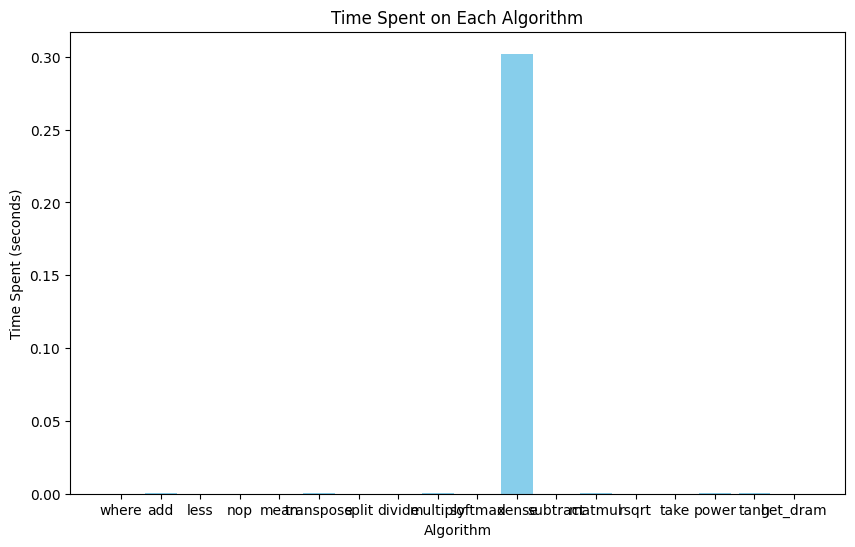

{'where': 3.976361205555637e-09, 'add': 0.00023870157491738298, 'less': 3.058739388888952e-10, 'nop': 6.331590535000158e-08, 'mean': 4.7043411801112134e-05, 'transpose': 7.893015818240156e-05, 'split': 1.2e-07, 'divide': 7.047335552000145e-07, 'multiply': 0.00022739402714453826, 'softmax': 4.228401331200086e-06, 'dense': 0.3022818336543124, 'subtract': 2.349111850666714e-05, 'matmul': 0.00018041179013120363, 'rsqrt': 3.058739388888953e-08, 'take': 3.058739388888952e-10, 'power': 6.859406603946807e-05, 'tanh': 0.00018041179013120372, 'get_dram': 0.0}
0.3033319632174611


In [6]:
time_spent = {}
largest = 0
for node in scheduled_flat_graph.node_list:
    time_spent.setdefault(node.algorithm, 0)
    time_spent[node.algorithm] += node.time_cost
    largest = max(largest, node.time_cost)

algorithms = list(time_spent.keys())
times = list(time_spent.values())

# Create the bar graph
plt.figure(figsize=(10, 6))
plt.bar(algorithms, times, color='skyblue')

# Add titles and labels
plt.title('Time Spent on Each Algorithm')
plt.xlabel('Algorithm')
plt.ylabel('Time Spent (seconds)')

# Show the bar graph
plt.show()

print (time_spent)
print(sum(times))
print(largest)


# 4 Memory Visualization

In [3]:
JSON_PATH = "/home/rjtomich/photonic_compiler/model_to_graph/gpt2_graph.json"
# JSON_PATH = '/home/rjtomich/photonic_compiler/model_to_graph/bert-base-uncased_graph.json'
# JSON_PATH = '/home/rjtomich/photonic_compiler/Pytorch-LeNet/simple_LeNet_graph.json'
# JSON_PATH = '/home/rjtomich/photonic_compiler/Pytorch-LeNet/simple_LeNet_graph_NoFusion.json'
with open(JSON_PATH, encoding="utf-8") as json_file:
    raw_json = json.load(json_file)  # returns json file as dict
    # print("... Json loaded ...")

# WEIGHT_VARIABLE = "time"
WEIGHT_VARIABLE = "energy"

graph = sg.StackGraph(raw_json=raw_json, weight_variable=WEIGHT_VARIABLE)
stacked_subgraphs = list(dijk.graph_partition(graph))
flat_subgraphs = dijk.select_nodes(
    stacked_subgraphs, weight_variable=WEIGHT_VARIABLE
)

# for graph in flat_subgraphs:
#     print(graph.weight_variable)

expanded_flat_subgraphs = dijk.expand_nodes(flat_subgraphs)
scheduled_flat_graph, end_time, break_points = dijk.schdeule_nodes(
    graph, expanded_flat_subgraphs
)

schedule_df = scheduled_flat_graph.create_schedule_data(write=True)
empty = test.schedule_validate(schedule_df)

dram, delta_dram, sram, delta_sram = dc.get_memory_profile(scheduled_flat_graph)

In [4]:
def plot_time_data(dram, sram, x_limit=None, log=False):
    dram_t, dram_v = zip(*dram)
    sram_t, sram_v = zip(*sram)

    plt.figure(figsize=(30, 5))  # Optional: Adjust figure size

    # plt.plot(dram_t, dram_v, linestyle='-', color='b', label='DRAM')
    # plt.plot(sram_t, sram_v, linestyle='--', color='r', label='SRAM')

    plt.scatter(sram_t, sram_v, color='r', label='SRAM')
    plt.scatter(dram_t, dram_v, color='b', label='DRAM')

    plt.xlabel('Time')
    plt.ylabel('Bits')
    plt.title('Memory')
    plt.legend()

    if x_limit:
        plt.xlim(x_limit)
        # Calculate y-axis limits based on the visible data range
        visible_dram_v = [v for t, v in dram if x_limit[0] <= t <= x_limit[1]]
        visible_sram_v = [v for t, v in sram if x_limit[0] <= t <= x_limit[1]]
        min_y = min(min(visible_dram_v), min(visible_sram_v))
        max_y = max(max(visible_dram_v), max(visible_sram_v))
        plt.ylim(min_y, max_y)

    if log:
        plt.yscale('symlog')

    plt.grid(True)
    plt.tight_layout()

    plt.show()

def subplot_time_data(dram, sram, x_limit=None, log=False):
    dram_t, dram_v = zip(*dram)
    sram_t, sram_v = zip(*sram)

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(30, 10), sharex=True)  # Create two subplots, sharing x-axis

    ax1.scatter(dram_t, dram_v, color='b', label='DRAM')  # Plot DRAM on the first subplot
    ax1.set_ylabel('Bits')
    ax1.set_title('Memory')
    ax1.legend()
    ax1.grid(True)

    ax2.scatter(sram_t, sram_v, color='r', label='SRAM')  # Plot SRAM on the second subplot
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Bits')
    ax2.legend()
    ax2.grid(True)

    if x_limit:
        ax1.set_xlim(x_limit)
        ax2.set_xlim(x_limit)

        # Calculate y-axis limits based on the visible data range
        visible_dram_v = [v for t, v in dram if x_limit[0] <= t <= x_limit[1]]
        visible_sram_v = [v for t, v in sram if x_limit[0] <= t <= x_limit[1]]
        min_y1 = min(visible_dram_v)
        max_y1 = max(visible_dram_v)
        min_y2 = min(visible_sram_v)
        max_y2 = max(visible_sram_v)

        ax1.set_ylim(min_y1, max_y1)
        ax2.set_ylim(min_y2, max_y2)

    if log:
        ax1.set_yscale('symlog')
        ax2.set_yscale('symlog')

    plt.tight_layout()
    plt.show()


312
55800


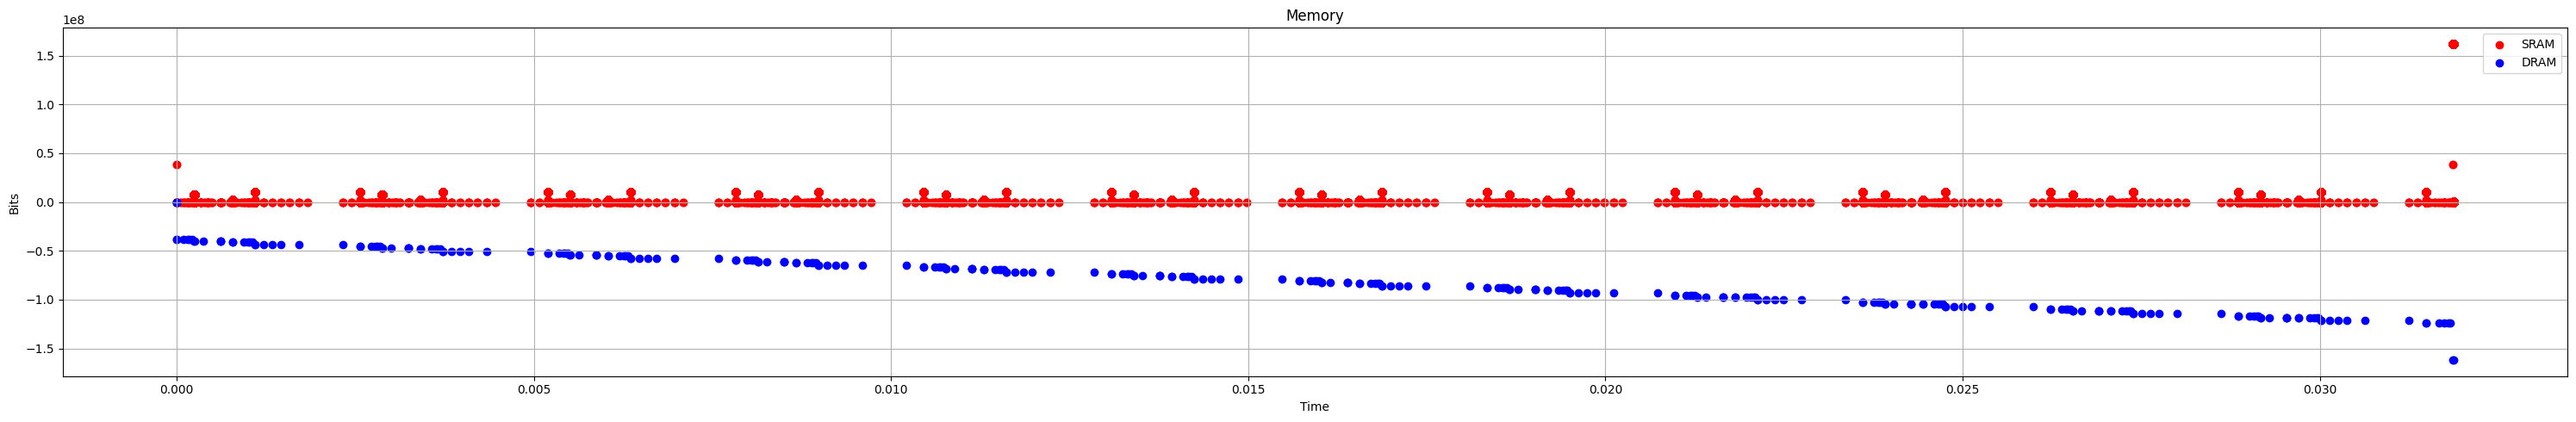

In [5]:
print(len(dram))
print(len(sram))

for i in sram:
    assert i[0] >= 0
    assert i[1] >= 0

plot_time_data(dram, sram)

# print(len(delta_dram))
# print(len(delta_sram))
# plot_time_data(delta_dram, delta_sram)


In [9]:
# PLOT EACH SUBSECTION
for i in range(len(break_points)-1):
    print(f'{break_points[i]} - {break_points[i+1]}')

    # plot_time_data(delta_dram, delta_sram, x_limit = (break_points[i], break_points[i+1]),log=True)
    # gv.make_schedule_diagram(scheduled_flat_graph, xlim_start=break_points[i], xlim_end=break_points[i+1])
    # subplot_time_data(delta_dram, delta_sram, x_limit = (break_points[i], break_points[i+1]),log=True)

    # plot_time_data(delta_dram, delta_sram, x_limit = (break_points[i] + 0.000246, break_points[i+1] - 0.000352), log=True)
    # gv.make_schedule_diagram(scheduled_flat_graph, xlim_start=break_points[i] + 0.000246, xlim_end=break_points[i+1] - 0.000352)
    # subplot_time_data(delta_dram, delta_sram, x_limit = (break_points[i] + 0.000246, break_points[i+1] - 0.000352), log=True)

    # plot_time_data(dram, sram, x_limit = (break_points[i], break_points[i+1]),log=True)
    # plot_time_data(dram, sram, x_limit = (break_points[i] + 0.000246, break_points[i+1] - 0.000352))

1.4e-07 - 0.09521598
0.09521598 - 0.2857421500000001
0.2857421500000001 - 0.3809579299999995
0.3809579299999995 - 0.5714840999999994
0.5714840999999994 - 0.6666998800000001
0.6666998800000001 - 0.8572260500000006
0.8572260500000006 - 0.9524418300000014
0.9524418300000014 - 1.142968000000002
1.142968000000002 - 1.238183780000002
1.238183780000002 - 1.428709950000002
1.428709950000002 - 1.523925730000002
1.523925730000002 - 1.714451900000002
1.714451900000002 - 1.809667680000002
1.809667680000002 - 2.0001938500000023
2.0001938500000023 - 2.0954096300000025
2.0954096300000025 - 2.285935800000003
2.285935800000003 - 2.381151580000003
2.381151580000003 - 2.5716777500000036
2.5716777500000036 - 2.666893530000004
2.666893530000004 - 2.8574197000000043
2.8574197000000043 - 2.9526354800000045
2.9526354800000045 - 3.143161650000005
3.143161650000005 - 3.238377430000005
3.238377430000005 - 3.4289036000000057
3.4289036000000057 - 3.428995850000006
3.428995850000006 - 3.4291189600000065
3.429118960

# 5 Energy

In [3]:
def plot_time_data(energy, x_limit=None, log=False):
    energy_t, energy_v = zip(*energy)

    plt.figure(figsize=(30, 5))  # Optional: Adjust figure size

    plt.plot(energy_t, energy_v, label='energy')

    plt.xlabel('Time [s]')
    plt.ylabel('Energy [J]')
    plt.title('Energy Comsumption')
    plt.legend()

    if x_limit:
        plt.xlim(x_limit)

        visable_energy_v = [v for t, v in energy if x_limit[0] <= t <= x_limit[1]]
        min_y = max(visable_energy_v)
        max_y = max(visable_energy_v)
        plt.ylim(min_y, max_y)

    if log:
        plt.yscale('symlog')

    plt.grid(True)
    plt.tight_layout()

    plt.show()

In [4]:
JSON_PATH = "/home/rjtomich/photonic_compiler/model_to_graph/gpt2_graph.json"
# JSON_PATH = '/home/rjtomich/photonic_compiler/model_to_graph/bert-base-uncased_graph.json'
# JSON_PATH = '/home/rjtomich/photonic_compiler/Pytorch-LeNet/simple_LeNet_graph.json'
# JSON_PATH = '/home/rjtomich/photonic_compiler/Pytorch-LeNet/simple_LeNet_graph_NoFusion.json'
with open(JSON_PATH, encoding="utf-8") as json_file:
    raw_json = json.load(json_file)  # returns json file as dict
    # print("... Json loaded ...")

# WEIGHT_VARIABLE = "time"
WEIGHT_VARIABLE = "energy"

graph = sg.StackGraph(raw_json=raw_json, weight_variable=WEIGHT_VARIABLE)
stacked_subgraphs = list(dijk.graph_partition(graph))
flat_subgraphs = dijk.select_nodes(
    stacked_subgraphs, weight_variable=WEIGHT_VARIABLE
)

expanded_flat_subgraphs = dijk.expand_nodes(flat_subgraphs)
scheduled_flat_graph, end_time, break_points = dijk.schdeule_nodes(
    graph, expanded_flat_subgraphs
)

schedule_df = scheduled_flat_graph.create_schedule_data(write=True)
empty = test.schedule_validate(schedule_df)

all_data
82657
Makespan: 0.03187 s
Total Energy Comsumption: 558815092.0 pico-joules


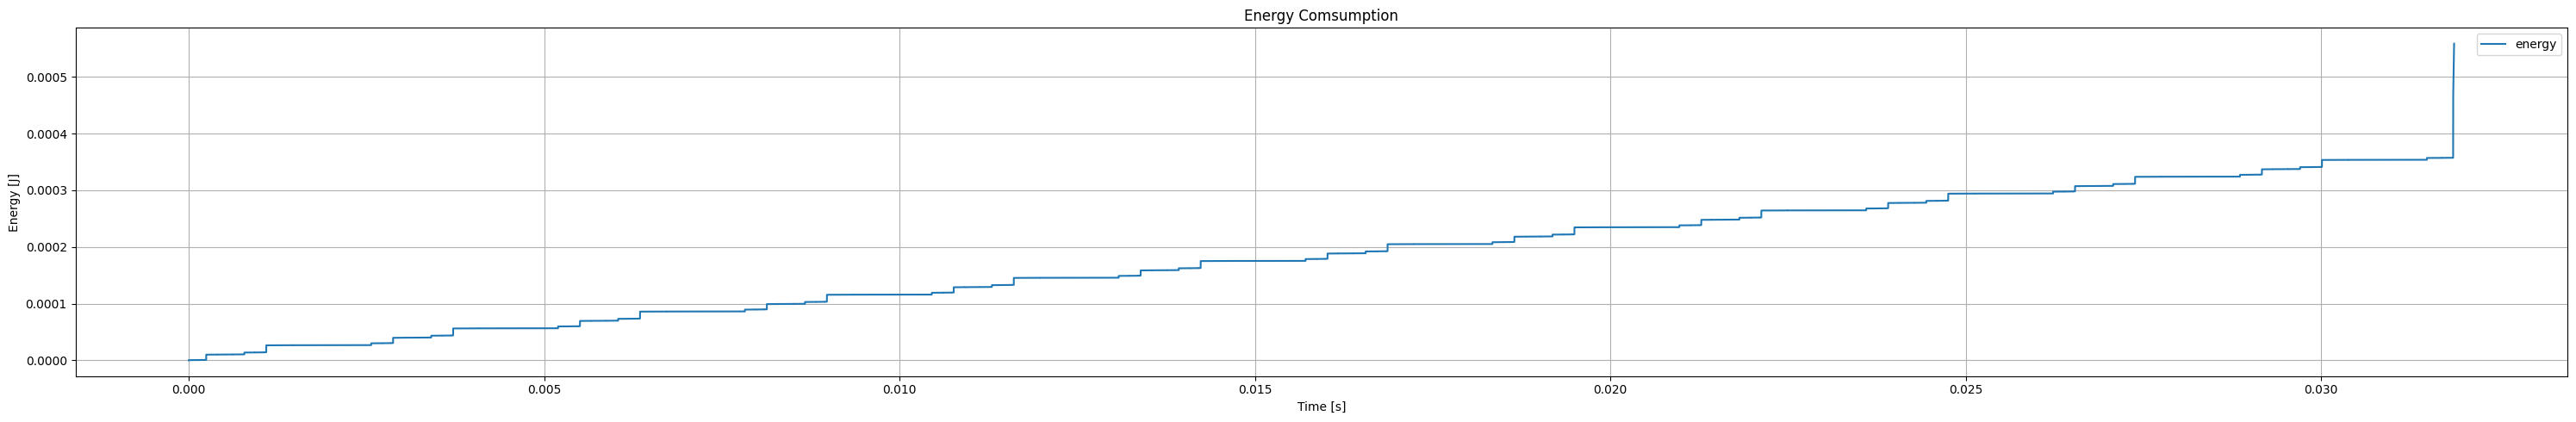

In [5]:
energy_data, delta_energy, total_energy = dc.get_energy_profile(scheduled_flat_graph)

print(len(energy_data))

print(f'Makespan: {end_time} s')
print(f'Total Energy Comsumption: {total_energy} pico-joules')

plot_time_data(energy_data, x_limit=None, log=False)
